In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader

# from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import data

In [2]:
# set metal backend (apple socs)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

## Using grid-interpolated dataset:

Autoencoders use image data, so we need to use image datasets.

In [3]:
root = Path.cwd().parents[0]
data = root/'data'/'interpolation_datasets'/'rec-interpolation2.nc'
ds = xr.open_dataset(data)
ds

<xarray.Dataset>
Dimensions:        (y: 707, x: 200, P: 8, V: 4)
Coordinates:
  * y              (y) float64 0.0 0.001 0.002 0.003 ... 0.703 0.704 0.705 0.706
  * x              (x) float64 0.0 0.001 0.002 0.003 ... 0.196 0.197 0.198 0.199
  * P              (P) float64 5.0 10.0 30.0 45.0 60.0 80.0 100.0 120.0
  * V              (V) float64 200.0 300.0 400.0 500.0
Data variables:
    potential (V)  (V, P, y, x) float64 ...
    Ne (#/m^-3)    (V, P, y, x) float64 ...
    Ar+ (#/m^-3)   (V, P, y, x) float64 ...
    Nm (#/m^-3)    (V, P, y, x) float64 ...
    Te (eV)        (V, P, y, x) float64 ...

In [4]:
vars = list(ds.data_vars)
vars

['potential (V)', 'Ne (#/m^-3)', 'Ar+ (#/m^-3)', 'Nm (#/m^-3)', 'Te (eV)']

In [5]:
scaler_dict = {}

In [6]:
def scale_np(array, var):
    global scaler_dict
    
    max = np.nanmax(array)
    min = np.nanmin(array) 

    scaler_dict[var] = (min, max)

    return (array - min) / (max - min)

In [7]:
data = np.float32(np.nan_to_num(np.stack([scale_np(ds[var].values, var) for var in vars])))
print(data.shape)
print(scaler_dict)

(5, 4, 8, 707, 200)
{'potential (V)': (-7.395783985231219e-16, 205.71708513606058), 'Ne (#/m^-3)': (3.071652512709689e-11, 1.6756994097021318e+16), 'Ar+ (#/m^-3)': (77385728216.21078, 1.675769409702132e+16), 'Nm (#/m^-3)': (10794684467551.668, 8.549053831954201e+18), 'Te (eV)': (0.049999999999999545, 11.672450000000012)}


Shuffle dimensions and combine V, P. 

Output shape should follow `(batch, height, width, channels)`

In [8]:
data = np.moveaxis(data, 0, 4)
data = data.reshape(32,707,200,5)
data = np.moveaxis(data, 3, 1)
data.shape

(32, 5, 707, 200)

Train test split

In [9]:
train, test = train_test_split(data, test_size = 1/32, shuffle=True)
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (31, 5, 707, 200)
test shape: (1, 5, 707, 200)


In [10]:
dataset = TensorDataset(torch.tensor(train, device=device))
trainloader = DataLoader(dataset, batch_size=1, shuffle=True)

Visualize one set of inputs

In [11]:
import matplotlib.patches as pat
import matplotlib.pyplot as plt
def draw_apparatus(ax):
    def edge_unit_conv(edges):
        u = 1e-1 # unit conv. mm -> cm
        return [(xy[0]*u,xy[1]*u) for xy in edges]
    
    pt_colors = {'fc':'white', 'ec':'black'}
    
    edges = [(0,453), (0,489), (95,489), (95,487), (40,487), (40,453)]
    patch_top = pat.Polygon(xy=edge_unit_conv(edges), fc=pt_colors['fc'], ec=pt_colors['ec'])
    ax.add_patch(patch_top)
    
    edges = [(0,0), (0,415), (95,415), (95,395), (90,395), (90,310), (120,310), (120,277), (90,277), (90,0)]
    patch_bottom = pat.Polygon(xy=edge_unit_conv(edges), fc=pt_colors['fc'], ec=pt_colors['ec'])
    ax.add_patch(patch_bottom)
    
    edges = [(122,224), (122,234), (185,234), (185,224)]
    patch_float = pat.Polygon(xy=edge_unit_conv(edges), fc=pt_colors['fc'], ec=pt_colors['ec'])
    ax.add_patch(patch_float)

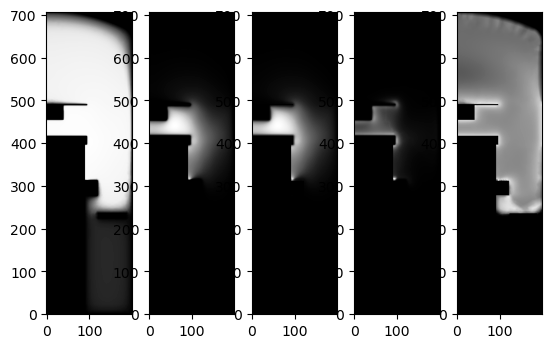

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=5)
for i, ax in enumerate(axs):
    ax.imshow(test[0,i,:,:], origin='lower', cmap='Greys_r')

## Define a model

In [13]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(5, 16, kernel_size=5, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
      nn.ReLU(),
    )

    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(8, 16, 3, 2),
      nn.ConvTranspose2d(16, 8, 3, 2),
      nn.Conv2d(8, 5, 3, padding=1)
    )
    

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    decoded = torchvision.transforms.functional.crop(decoded, 0, 0, 707, 200) 
    return decoded

In [14]:
# hyperparameters
epochs = 300
learning_rate = 1e-3

In [15]:
model = Autoencoder()
model.to(device)  # move model to gpu
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(5, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (2): Conv2d(8, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


Weights for each variable is introduced. `expand_dims` is used to add singleton dimensions to match the output tensor's dimensions.

By applying weights to the loss of each output, the model can be trained to pay more attention to outputs with higher weights and minimize the error in these outputs more aggressively. I don't know if this is right, but the model doesn't seem to adapt to the weights.

In [17]:
weights_np = np.expand_dims(np.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=np.float32), axis=(0, 2, 3))
weights = torch.tensor(weights_np, device=device)
weights.size()

torch.Size([1, 5, 1, 1])

In [18]:
epoch_loss = []
for epoch in tqdm(range(epochs)):
    # loop = tqdm(trainloader)

    for i, batch_data in enumerate(trainloader):
        # get inputs
        inputs = batch_data[0]
        optimizer.zero_grad()

        # record loss
        running_loss = 0.0

        outputs = model(inputs)
        loss = criterion(outputs * weights, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # loop.set_description(f"Epoch {epoch+1}/{epochs}")
        
    epoch_loss.append(running_loss)
    


  0%|          | 0/300 [00:00<?, ?it/s]

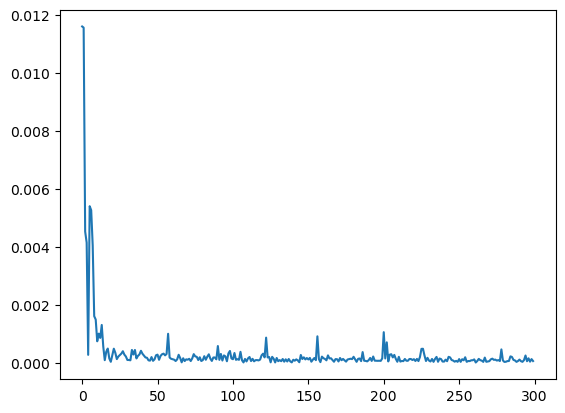

In [19]:
fig, ax = plt.subplots()
ax.plot(epoch_loss)
ax.ticklabel_format(axis='y',style='sci')

In [29]:
test1 = torch.tensor(np.expand_dims(train[11], axis=0), device=device)

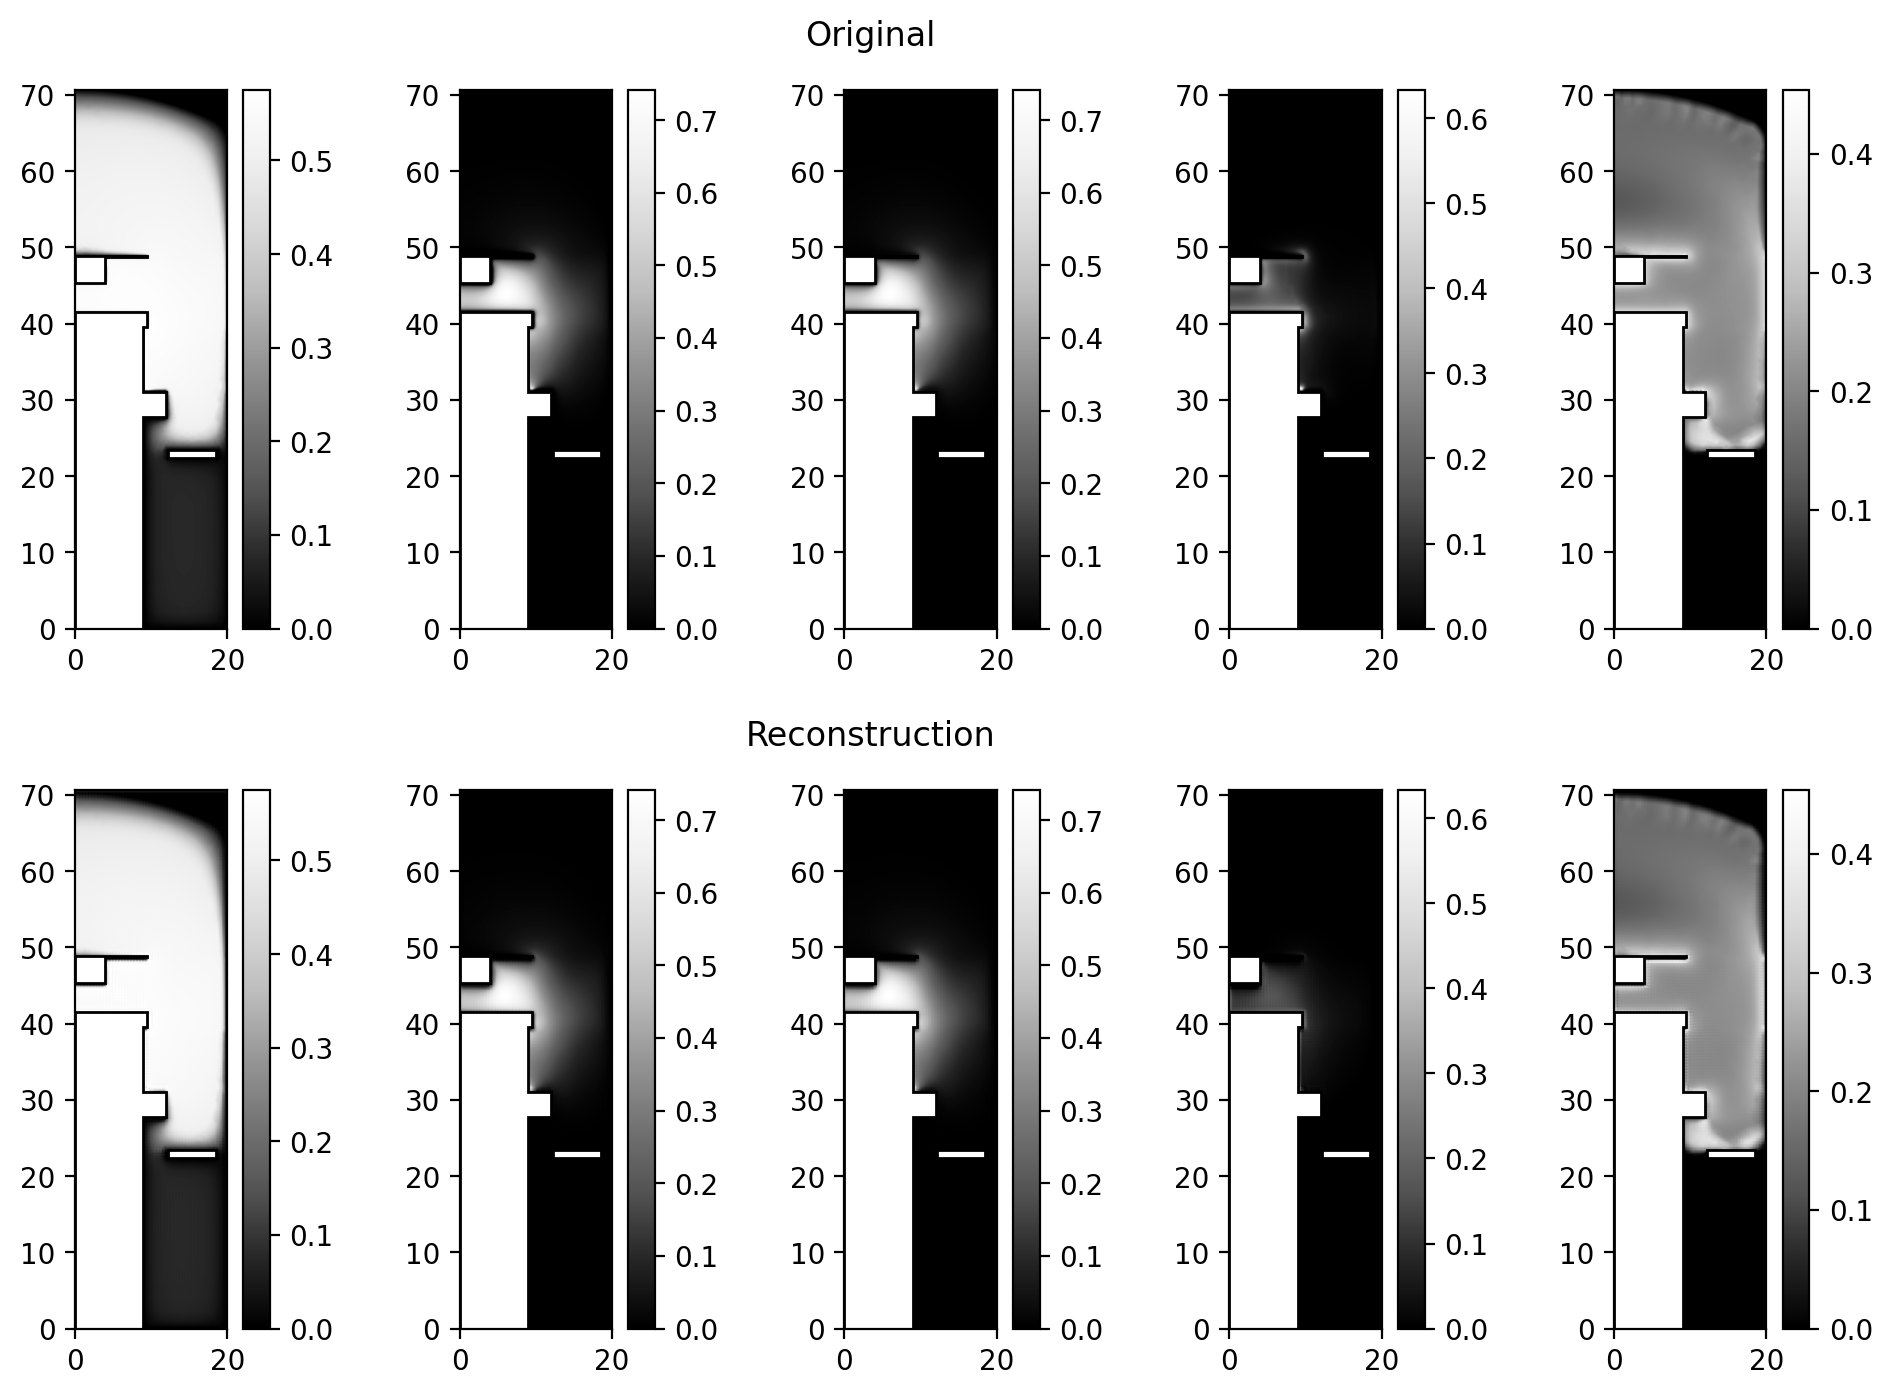

In [31]:
fig = plt.figure(figsize=(12, 7), dpi=200)
subfigs = fig.subfigures(nrows=2)

axs1 = subfigs[0].subplots(nrows=1, ncols=5)
axs2 = subfigs[1].subplots(nrows=1, ncols=5)

subfigs[1].suptitle('Reconstruction')
subfigs[0].suptitle('Original')

reference = test
cbar_ranges = [(reference[0,i,:,:].min(), reference[0,i,:,:].max()) for i in range(5)]

with torch.no_grad():
    # encoded = model.encoder(test_tensor)
    encoded = model.encoder(torch.tensor(reference, device=device))
    decoded = model.decoder(encoded).cpu().numpy()

for i in range(5):
    org = axs1[i].imshow(reference[0,i,:,:], origin='lower', extent=[0,20,0, 70.7], cmap='Greys_r')
    draw_apparatus(axs1[i])
    plt.colorbar(org)
    rec = axs2[i].imshow(decoded[0,i,:,:], origin='lower', extent=[0,20,0, 70.7],
                         vmin=cbar_ranges[i][0], vmax=cbar_ranges[i][1], cmap='Greys_r')
    draw_apparatus(axs2[i])
    plt.colorbar(rec)